In [24]:
import os
import json
import random
from tqdm import tqdm
from PIL import Image as PILImage, ImageDraw, ImageFont
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import matplotlib.pyplot as plt
import numpy as np

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from pprint import pprint

In [25]:
# ================================== ОПРЕДЕЛЕНИЕ КЛАССОВ И МАППИНГА ==================================

# root = "data"  # для полного датасета
root = "data_mini"

train_ann_path = os.path.join(root, "train", "_annotations.coco.json")
with open(train_ann_path, "r") as f:
    coco_sample = json.load(f)

categories_sorted = sorted(coco_sample['categories'], key=lambda x: x['id'])
cat_id_to_idx = {cat['id']: idx for idx, cat in enumerate(categories_sorted)}
idx_to_cat_name = {idx: cat['name'] for idx, cat in enumerate(categories_sorted)}
num_classes = len(categories_sorted)

print(f"Обнаружено классов: {num_classes}")
print("Классы:")
for idx, name in idx_to_cat_name.items():
    print(f"  {idx}: {name}")

# Цвета для разных классов
CLASS_COLORS = {
    0: 'red',
    1: 'lime',
    2: 'blue'
}
DEFAULT_COLOR = 'white'

Обнаружено классов: 3
Классы:
  0: spaces
  1: space-empty
  2: space-occupied


In [26]:
# ================================== КОНВЕРТАЦИЯ COCO → YOLO ==================================

def coco_to_yolo_bbox(bbox, img_w, img_h):
    x, y, w, h = bbox
    cx = x + w / 2.0
    cy = y + h / 2.0
    return [cx / img_w, cy / img_h, w / img_w, h / img_h]

def convert_coco_to_yolo(root_dir, split="train", output_dir="yolo_dataset"):
    split_dir = os.path.join(root_dir, split)
    ann_path = os.path.join(split_dir, "_annotations.coco.json")

    with open(ann_path, "r") as f:
        coco = json.load(f)

    img_out_dir = os.path.join(output_dir, "images", split)
    lbl_out_dir = os.path.join(output_dir, "labels", split)
    os.makedirs(img_out_dir, exist_ok=True)
    os.makedirs(lbl_out_dir, exist_ok=True)

    images = {img["id"]: img for img in coco["images"]}
    annotations = {}
    for ann in coco["annotations"]:
        img_id = ann["image_id"]
        annotations.setdefault(img_id, []).append(ann)

    for img_id, img_info in tqdm(images.items(), desc=f"Converting {split}"):
        file_name = img_info["file_name"]
        img_path = os.path.join(split_dir, file_name)
        if not os.path.exists(img_path):
            continue

        img = PILImage.open(img_path)
        img_w, img_h = img.size
        img.save(os.path.join(img_out_dir, file_name))

        label_path = os.path.join(lbl_out_dir, os.path.splitext(file_name)[0] + ".txt")
        anns = annotations.get(img_id, [])

        with open(label_path, "w") as f:
            for ann in anns:
                if ann.get("iscrowd", 0) == 1:
                    continue
                yolo_bbox = coco_to_yolo_bbox(ann["bbox"], img_w, img_h)
                class_id = cat_id_to_idx[ann["category_id"]]
                line = f"{class_id} " + " ".join(f"{v:.6f}" for v in yolo_bbox)
                f.write(line + "\n")

out = "yolo_dataset"
for split in ["train", "valid", "test"]:
    convert_coco_to_yolo(root, split, out)

Converting test: 100%|██████████| 198/198 [00:00<00:00, 338.00it/s]


In [27]:
DATA_ROOT = "yolo_dataset"
TRAIN_IMAGES = os.path.join(DATA_ROOT, "images/train")
TRAIN_LABELS = os.path.join(DATA_ROOT, "labels/train")
VALID_IMAGES = os.path.join(DATA_ROOT, "images/valid")
VALID_LABELS = os.path.join(DATA_ROOT, "labels/valid")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

Device: cpu



In [28]:
# ================================== ДАТАСЕТ ==================================

class ImprovedCraterDataset(Dataset):
    def __init__(self, images_dir, labels_dir, img_size=416, grid_size=13, augment=False):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.img_size = img_size
        self.grid_size = grid_size
        self.augment = augment
        self.image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        if augment:
            self.augment_transform = transforms.Compose([
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
            ])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_file)
        original_img = PILImage.open(img_path).convert('RGB')
        original_size = original_img.size
        
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(self.labels_dir, label_file)
        
        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id = int(parts[0])
                        cx = float(parts[1]) * original_size[0]
                        cy = float(parts[2]) * original_size[1]
                        w = float(parts[3]) * original_size[0]
                        h = float(parts[4]) * original_size[1]
                        boxes.append((cx, cy, w, h, class_id))
        
        img = original_img.copy()
        if self.augment and random.random() > 0.5:
            img = self.augment_transform(img)
        
        img_resized = img.resize((self.img_size, self.img_size), PILImage.BILINEAR)
        img_tensor = transforms.ToTensor()(img_resized)
        img_tensor = self.normalize(img_tensor)
        
        target = torch.zeros((5 + num_classes, self.grid_size, self.grid_size))
        
        scale_x = self.img_size / original_size[0]
        scale_y = self.img_size / original_size[1]
        
        for cx, cy, w, h, class_id in boxes:
            x_center = cx * scale_x
            y_center = cy * scale_y
            width = w * scale_x
            height = h * scale_y
            
            x_norm = x_center / self.img_size
            y_norm = y_center / self.img_size
            w_norm = width / self.img_size
            h_norm = height / self.img_size
            
            grid_x = int(x_norm * self.grid_size)
            grid_y = int(y_norm * self.grid_size)
            grid_x = max(0, min(self.grid_size - 1, grid_x))
            grid_y = max(0, min(self.grid_size - 1, grid_y))
            
            cell_x = x_norm * self.grid_size - grid_x
            cell_y = y_norm * self.grid_size - grid_y
            
            if target[4, grid_y, grid_x] == 0:
                target[0, grid_y, grid_x] = cell_x
                target[1, grid_y, grid_x] = cell_y
                target[2, grid_y, grid_x] = w_norm
                target[3, grid_y, grid_x] = h_norm
                target[4, grid_y, grid_x] = 1.0
                target[5 + class_id, grid_y, grid_x] = 1.0
        
        return img_tensor, target, original_img
    
def custom_collate_fn(batch):
    img_tensors = torch.stack([item[0] for item in batch])
    targets = torch.stack([item[1] for item in batch])
    original_imgs = [item[2] for item in batch]
    return img_tensors, targets, original_imgs

In [29]:
train_dataset_improved_20 = ImprovedCraterDataset(TRAIN_IMAGES, TRAIN_LABELS, img_size=640, grid_size=20, augment=True)
valid_dataset_improved_20 = ImprovedCraterDataset(VALID_IMAGES, VALID_LABELS, img_size=640, grid_size=20, augment=False)

train_dataset_improved_13 = ImprovedCraterDataset(TRAIN_IMAGES, TRAIN_LABELS, img_size=416, grid_size=13, augment=True)
valid_dataset_improved_13 = ImprovedCraterDataset(VALID_IMAGES, VALID_LABELS, img_size=416, grid_size=13, augment=False)

In [30]:
# ================================== ДАТАЛОАДЕРЫ ==================================

batch_size = 2
# model 1
train_loader_20 = DataLoader(
    train_dataset_improved_20,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=custom_collate_fn,
    pin_memory=torch.cuda.is_available()
)

valid_loader_20 = DataLoader(
    valid_dataset_improved_20,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=custom_collate_fn,
    pin_memory=torch.cuda.is_available()
)


# model 2
train_loader_13 = DataLoader(
    train_dataset_improved_13,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=custom_collate_fn,
    pin_memory=torch.cuda.is_available()
)

valid_loader_13 = DataLoader(
    valid_dataset_improved_13,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=custom_collate_fn,
    pin_memory=torch.cuda.is_available()
)

In [31]:
# ================================== LOSS ==================================

def compute_iou_loss(pred_boxes, target_boxes):
    pred_x1 = pred_boxes[:, 0] - pred_boxes[:, 2] / 2
    pred_y1 = pred_boxes[:, 1] - pred_boxes[:, 3] / 2
    pred_x2 = pred_boxes[:, 0] + pred_boxes[:, 2] / 2
    pred_y2 = pred_boxes[:, 1] + pred_boxes[:, 3] / 2

    target_x1 = target_boxes[:, 0] - target_boxes[:, 2] / 2
    target_y1 = target_boxes[:, 1] - target_boxes[:, 3] / 2
    target_x2 = target_boxes[:, 0] + target_boxes[:, 2] / 2
    target_y2 = target_boxes[:, 1] + target_boxes[:, 3] / 2

    inter_x1 = torch.max(pred_x1, target_x1)
    inter_y1 = torch.max(pred_y1, target_y1)
    inter_x2 = torch.min(pred_x2, target_x2)
    inter_y2 = torch.min(pred_y2, target_y2)

    inter_area = (inter_x2 - inter_x1).clamp(min=0) * (inter_y2 - inter_y1).clamp(min=0)
    union_area = pred_boxes[:, 2] * pred_boxes[:, 3] + target_boxes[:, 2] * target_boxes[:, 3] - inter_area
    iou = inter_area / (union_area + 1e-6)
    return iou

def improved_detection_loss(pred, target, lambda_coord=5.0, lambda_iou=2.0, lambda_noobj=0.5, lambda_class=1.0):
    B, _, S, _ = pred.shape

    obj_mask = target[:, 4, :, :] == 1.0
    noobj_mask = target[:, 4, :, :] == 0.0

    pred_xy = torch.sigmoid(pred[:, 0:2, :, :])
    pred_wh = torch.sigmoid(pred[:, 2:4, :, :])
    pred_conf = torch.sigmoid(pred[:, 4:5, :, :])
    pred_class = pred[:, 5:, :, :]

    pred_xy_flat = pred_xy.permute(0, 2, 3, 1).contiguous()
    pred_wh_flat = pred_wh.permute(0, 2, 3, 1).contiguous()
    pred_conf_flat = pred_conf.permute(0, 2, 3, 1).squeeze(-1)
    pred_class_flat = pred_class.permute(0, 2, 3, 1).contiguous()

    target_xy_flat = target[:, 0:2, :, :].permute(0, 2, 3, 1).contiguous()
    target_wh_flat = target[:, 2:4, :, :].permute(0, 2, 3, 1).contiguous()

    coord_loss = torch.tensor(0.0, device=pred.device)
    if obj_mask.sum() > 0:
        xy_loss = F.mse_loss(pred_xy_flat[obj_mask], target_xy_flat[obj_mask])
        wh_loss = F.mse_loss(pred_wh_flat[obj_mask], target_wh_flat[obj_mask])
        coord_loss = lambda_coord * (xy_loss + wh_loss)

    iou_loss_val = torch.tensor(0.0, device=pred.device)
    if obj_mask.sum() > 0:
        pred_boxes = torch.cat([pred_xy_flat[obj_mask], pred_wh_flat[obj_mask]], dim=1)
        target_boxes = torch.cat([target_xy_flat[obj_mask], target_wh_flat[obj_mask]], dim=1)
        iou_loss_val = lambda_iou * (1 - compute_iou_loss(pred_boxes, target_boxes)).mean()

    obj_loss = F.binary_cross_entropy(pred_conf_flat[obj_mask], torch.ones_like(pred_conf_flat[obj_mask])) if obj_mask.sum() > 0 else torch.tensor(0.0, device=pred.device)
    noobj_loss = lambda_noobj * F.binary_cross_entropy(pred_conf_flat[noobj_mask], torch.zeros_like(pred_conf_flat[noobj_mask])) if noobj_mask.sum() > 0 else torch.tensor(0.0, device=pred.device)

    class_loss = torch.tensor(0.0, device=pred.device)
    if obj_mask.sum() > 0:
        class_loss = lambda_class * F.cross_entropy(pred_class_flat[obj_mask], torch.argmax(target[:, 5:, :, :], dim=1)[obj_mask])

    total_loss = coord_loss + iou_loss_val + obj_loss + noobj_loss + class_loss
    return total_loss

In [32]:
# ================================== ВЫЧИСЛЕНИЕ mAP ==================================
def decode_predictions_single(pred, img_size=640, conf_threshold=0.3):
    S = pred.shape[1]
    cell_size = img_size / S
    boxes = []
    
    pred = pred.clone()
    pred[0:2] = torch.sigmoid(pred[0:2])        # xy
    pred[2:4] = torch.sigmoid(pred[2:4])        # wh 
    pred[4] = torch.sigmoid(pred[4])            # confidence
    pred[5:] = torch.softmax(pred[5:], dim=0)   # class probs
    
    for gy in range(S):
        for gx in range(S):
            conf = pred[4, gy, gx].item()
            class_probs = pred[5:, gy, gx]
            class_id = torch.argmax(class_probs).item()
            score = conf * class_probs[class_id].item()
            
            if score < conf_threshold:
                continue
                
            cx = (gx + pred[0, gy, gx].item()) * cell_size
            cy = (gy + pred[1, gy, gx].item()) * cell_size
            w = pred[2, gy, gx].item() * img_size
            h = pred[3, gy, gx].item() * img_size
            
            x1 = max(0, cx - w / 2)
            y1 = max(0, cy - h / 2)
            x2 = min(img_size, cx + w / 2)
            y2 = min(img_size, cy + h / 2)
            
            if x1 >= x2 or y1 >= y2:
                continue
                
            boxes.append((x1, y1, x2, y2, score, class_id))
    
    return boxes

from torchvision.ops import nms, batched_nms
def apply_nms_to_decoded_boxes(boxes, iou_threshold=0.5):
    if not boxes:
        return boxes
    
    boxes_tensor = torch.tensor([b[:4] for b in boxes], dtype=torch.float32)
    scores_tensor = torch.tensor([b[4] for b in boxes])
    labels_tensor = torch.tensor([b[5] for b in boxes], dtype=torch.int64)
    
    keep = batched_nms(boxes_tensor, scores_tensor, labels_tensor, iou_threshold)
    
    return [boxes[i] for i in keep.tolist()]

def compute_map(model, dataloader, device, conf_threshold=0.3):
    model.eval()
    metric = MeanAveragePrecision(class_metrics=True, backend="faster_coco_eval")
    metric = metric.to(device)
    
    with torch.no_grad():
        for images, targets, _ in tqdm(dataloader, desc="Вычисление mAP"):
            images = images.to(device)
            outputs = model(images)
            
            batch_size = images.size(0)
            S = targets.shape[2]
            img_size = 640
            cell_size = img_size / S
            
            batch_preds = []
            batch_targets = []
            
            for b in range(batch_size):
                # Предсказания
                pred_boxes = decode_predictions_single(outputs[b], img_size=img_size, conf_threshold=conf_threshold)
                pred_boxes = apply_nms_to_decoded_boxes(pred_boxes, iou_threshold=0.5)
                
                if pred_boxes:
                    boxes = torch.tensor([box[:4] for box in pred_boxes], device=device, dtype=torch.float32)
                    scores = torch.tensor([box[4] for box in pred_boxes], device=device, dtype=torch.float32)
                    labels = torch.tensor([box[5] for box in pred_boxes], device=device, dtype=torch.int64)
                else:
                    boxes = torch.zeros((0, 4), device=device)
                    scores = torch.zeros(0, device=device)
                    labels = torch.zeros(0, device=device, dtype=torch.int64)
                
                batch_preds.append({"boxes": boxes, "scores": scores, "labels": labels})
                
                # Ground Truth
                target = targets[b]
                gt_boxes = []
                gt_labels = []
                
                for gy in range(S):
                    for gx in range(S):
                        if target[4, gy, gx] == 1.0:
                            cx = (gx + target[0, gy, gx].item()) * cell_size
                            cy = (gy + target[1, gy, gx].item()) * cell_size
                            w = target[2, gy, gx].item() * img_size
                            h = target[3, gy, gx].item() * img_size
                            
                            x1 = max(0, cx - w / 2)
                            y1 = max(0, cy - h / 2)
                            x2 = min(img_size, cx + w / 2)
                            y2 = min(img_size, cy + h / 2)
                            
                            if x1 >= x2 or y1 >= y2:
                                continue
                            
                            class_id_gt = torch.argmax(target[5:, gy, gx]).item()
                            gt_boxes.append([x1, y1, x2, y2])
                            gt_labels.append(class_id_gt)
                
                if gt_boxes:
                    gt_boxes = torch.tensor(gt_boxes, device=device, dtype=torch.float32)
                    gt_labels = torch.tensor(gt_labels, device=device, dtype=torch.int64)
                else:
                    gt_boxes = torch.zeros((0, 4), device=device)
                    gt_labels = torch.zeros(0, device=device, dtype=torch.int64)
                
                batch_targets.append({"boxes": gt_boxes, "labels": gt_labels})
            
            metric.update(batch_preds, batch_targets)
    
    result = metric.compute()
    metric.reset()
    return result

In [33]:
# ================================== МОДЕЛЬ ==================================

class CraterDetectorResNet(nn.Module):
    def __init__(self, num_classes=3, pretrained=True):
        super().__init__()
        weights = ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        resnet = models.resnet18(weights=weights)
        
        self.features = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
            resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4,
        )
        
        self.refine = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
        )
        
        self.detect = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(64, 5 + num_classes, 1),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.refine(x)
        x = self.detect(x)
        return x

model = CraterDetectorResNet(pretrained=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-6)

In [34]:
def decode_predictions(pred, img_size=640, conf_threshold=0.3):
    """
    Декодирует предсказания модели.
    pred: тензор формы (1, 5 + num_classes, S, S) или (5 + num_classes, S, S)
    """
   
    if pred.dim() == 4:
        pred = pred.squeeze(0)
    elif pred.dim() != 3:
        raise ValueError(f"Ожидается 3D или 4D тензор, получено {pred.dim()}D")

    C, S, _ = pred.shape
    cell_size = img_size / S
    boxes = []

    # Правильно применяем активации
    xy = torch.sigmoid(pred[0:2])                    # (2, S, S)
    wh = torch.sigmoid(pred[2:4])                    # (2, S, S)
    obj_conf = torch.sigmoid(pred[4:5])              # (1, S, S) 
    class_probs = torch.softmax(pred[5:], dim=0)     # (num_classes, S, S)

    for gy in range(S):
        for gx in range(S):
            conf = obj_conf[0, gy, gx].item() 
            class_prob = class_probs[:, gy, gx]
            class_id = torch.argmax(class_prob).item()
            score = conf * class_prob[class_id].item()

            if score < conf_threshold:
                continue

            cx = (gx + xy[0, gy, gx].item()) * cell_size
            cy = (gy + xy[1, gy, gx].item()) * cell_size
            w = wh[0, gy, gx].item() * img_size
            h = wh[1, gy, gx].item() * img_size

            x1 = max(0, cx - w / 2)
            y1 = max(0, cy - h / 2)
            x2 = min(img_size, cx + w / 2)
            y2 = min(img_size, cy + h / 2)

            if x1 >= x2 or y1 >= y2:
                continue

            boxes.append((x1, y1, x2, y2, score, class_id))

    return boxes

In [35]:
def train_epoch(model, train_loader, optimizer, device):

    model.train()
    train_loss = 0.0
    
    pbar = tqdm(train_loader, desc="Training")
    
    for images, targets, _ in pbar:
        images = images.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = improved_detection_loss(outputs, targets)
        
        loss.backward()
        optimizer.step()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()
        train_loss += loss.item()
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
        })
    
    return train_loss


def validate_epoch(model, val_loader, device):

    model.eval()
    
    val_loss = 0.0
    
    pbar = tqdm(val_loader, desc="Validation")
    
    with torch.no_grad():
        for images, targets, _ in pbar:
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)
            
            loss = improved_detection_loss(outputs, targets)
            val_loss += loss.item()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
            })
    
    return val_loss

In [36]:
# ================================== ОБУЧЕНИЕ ==================================

def train_model(model, train_loader, valid_loader, optimizer, scheduler, file_name, num_epochs=30):
    history = {'train_loss': [], 'valid_loss': [], 'map50': []}
    best_map50 = 0.0
    model = model.to(device)
    
    for epoch in range(num_epochs):
        print(f"Эпоха {epoch+1}/{num_epochs}")

         # Здесь происходит основное обучение
        train_loss = train_epoch(
            model, train_loader, optimizer, device
        )
        history['train_loss'].append(train_loss / len(train_loader))
       
        # Валидация 
        val_loss = validate_epoch(
            model, valid_loader, device
        )
        
        history['valid_loss'].append(val_loss / len(valid_loader))
        
        # Вычисление mAP
        map_result = compute_map(model, valid_loader, device, conf_threshold=0.3)
        current_map = map_result['map'].item()
        current_map50 = map_result['map_50'].item()
        history['map50'].append(current_map50)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {history['train_loss'][-1]:.4f}")
        print(f"  Val Loss:   {history['valid_loss'][-1]:.4f}")
        print(f"  mAP@0.5:0.95: {current_map:.4f}")
        print(f"  mAP@0.5     : {current_map50:.4f}")
        
        scheduler.step()
        
        if current_map50 > best_map50:
            best_map50 = current_map50
            torch.save(model.state_dict(), file_name)
            print(f"  >>> Сохранена лучшая модель (mAP@0.5 = {best_map50:.4f})")
    
    return history

In [37]:
# ================================== ЗАПУСК ==================================
model_20 = CraterDetectorResNet(num_classes=3, pretrained=True)

backbone_params = []
for name, param in model_20.named_parameters():
    if 'conv1' in name or 'bn1' in name or 'layer' in name:
        backbone_params.append(param)

# Head (новые слои) - больший LR
head_params = []
for name, param in model_20.named_parameters():
    if 'refine' in name or 'detect' in name:
        head_params.append(param)

optimizer_20 = torch.optim.AdamW([
    {'params': backbone_params, 'lr': 1e-4},   # Маленький LR для backbone
    {'params': head_params, 'lr': 1e-3}        # Больший LR для head
], weight_decay=1e-4)

scheduler_20 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_20, T_0=10, T_mult=2, eta_min=1e-6)

history_20 = train_model(model=model_20, train_loader=train_loader_20, valid_loader=valid_loader_20, optimizer=optimizer_20, scheduler=scheduler_20, file_name="best_yolo_20.pth", num_epochs=5)


Эпоха 1/5


Вычисление mAP: 100%|██████████| 42/42 [00:12<00:00,  3.31it/s]


Epoch 1/5
  Train Loss: 2.7967
  Val Loss:   2.4171
  mAP@0.5:0.95: 0.0692
  mAP@0.5     : 0.3208
  >>> Сохранена лучшая модель (mAP@0.5 = 0.3208)
Эпоха 2/5


Вычисление mAP: 100%|██████████| 42/42 [00:12<00:00,  3.28it/s]


Epoch 2/5
  Train Loss: 2.2739
  Val Loss:   2.2245
  mAP@0.5:0.95: 0.0755
  mAP@0.5     : 0.2868
Эпоха 3/5


Вычисление mAP: 100%|██████████| 42/42 [00:14<00:00,  2.90it/s]


Epoch 3/5
  Train Loss: 2.0501
  Val Loss:   1.9136
  mAP@0.5:0.95: 0.1313
  mAP@0.5     : 0.5195
  >>> Сохранена лучшая модель (mAP@0.5 = 0.5195)
Эпоха 4/5


Вычисление mAP: 100%|██████████| 42/42 [00:13<00:00,  3.14it/s]


Epoch 4/5
  Train Loss: 1.8375
  Val Loss:   1.7561
  mAP@0.5:0.95: 0.1433
  mAP@0.5     : 0.4679
Эпоха 5/5


Вычисление mAP: 100%|██████████| 42/42 [00:13<00:00,  3.13it/s]


Epoch 5/5
  Train Loss: 1.6824
  Val Loss:   1.6703
  mAP@0.5:0.95: 0.0569
  mAP@0.5     : 0.2716


In [38]:
# ================================== ВИЗУАЛИЗАЦИЯ ==================================

def visualize_results(model, history, valid_dataset, device, num_images=3, conf_threshold=0.3):
    model.eval()

    # 1. Графики обучения
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2, color='tab:blue')
    plt.plot(history['valid_loss'], label='Valid Loss', marker='o', linewidth=2, color='tab:orange')
    plt.title('Кривые потери', fontsize=16)
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history['map50'], label='mAP@0.5', marker='o', linewidth=3, color='green')
    plt.title('mAP@0.5 на валидации', fontsize=16)
    plt.xlabel('Эпоха')
    plt.ylabel('mAP@0.5')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.suptitle('Результаты обучения модели', fontsize=18)
    plt.tight_layout()
    plt.show()

    legend_fig = plt.figure(figsize=(4, 3))
    legend_elements = [
        plt.Rectangle((0,0), 1, 1, facecolor='white', edgecolor=color, linewidth=2, label=name)
        for idx, (color, name) in enumerate(zip(
            [CLASS_COLORS.get(i, DEFAULT_COLOR) for i in range(num_classes)],
            [idx_to_cat_name.get(i, f"class_{i}") for i in range(num_classes)]
        ))
    ]
    legend_fig.legend(handles=legend_elements, loc='center', title="Классы", fontsize=12, title_fontsize=14)
    legend_fig.tight_layout()
    plt.show()

    # 2. Сравнение: Ground Truth vs Предсказание
    indices = random.sample(range(len(valid_dataset)), num_images)
    
    plt.figure(figsize=(14, 6 * num_images))

    S = valid_dataset.grid_size
    cell_size = 640 / S

    for row_idx, idx in enumerate(indices):

        img_tensor, target, original_img = valid_dataset[idx]
        img_tensor = img_tensor.unsqueeze(0).to(device)
        
        with torch.no_grad():
            pred = model(img_tensor)
        pred_boxes = decode_predictions(pred, img_size=640, conf_threshold=conf_threshold)
        pred_boxes = apply_nms_to_decoded_boxes(pred_boxes, iou_threshold=0.5)

        # Ground Truth
        gt_img = original_img.copy()
        draw_gt = ImageDraw.Draw(gt_img)
        try:
            font = ImageFont.truetype("arial.ttf", 28)
        except:
            font = ImageFont.load_default()

        for gy in range(S):
            for gx in range(S):
                if target[4, gy, gx] == 1:
                    cx = (gx + target[0, gy, gx].item()) * cell_size
                    cy = (gy + target[1, gy, gx].item()) * cell_size
                    w = target[2, gy, gx].item() * 640
                    h = target[3, gy, gx].item() * 640

                    x1 = max(0, cx - w/2)
                    y1 = max(0, cy - h/2)
                    x2 = min(640, cx + w/2)
                    y2 = min(640, cy + h/2)

                    if x1 >= x2 or y1 >= y2:
                        continue

                    class_id = torch.argmax(target[5:, gy, gx]).item()
                    color = CLASS_COLORS.get(class_id, DEFAULT_COLOR)
                    draw_gt.rectangle([x1, y1, x2, y2], outline=color, width=6)
                    label = idx_to_cat_name.get(class_id, 'unknown')
                    draw_gt.text((x1 + 10, y1 + 10), label, fill=color, font=font, stroke_width=3, stroke_fill='black')

        plt.subplot(num_images, 2, row_idx * 2 + 1)
        plt.imshow(gt_img)
        plt.title(f'Ground Truth (изображение {row_idx + 1})', fontsize=16)
        plt.axis('off')

        # Предсказание
        pred_img = original_img.copy()
        draw = ImageDraw.Draw(pred_img)

        for box in pred_boxes:
            x1, y1, x2, y2, score, class_id = box
            color = CLASS_COLORS.get(class_id, DEFAULT_COLOR)
            draw.rectangle([x1, y1, x2, y2], outline=color, width=6)
            label = f"{idx_to_cat_name.get(class_id, 'unknown')} {score:.2f}"
            draw.text((x1 + 10, y1 + 10), label, fill=color, font=font, stroke_width=3, stroke_fill='black')

        plt.subplot(num_images, 2, row_idx * 2 + 2)
        plt.imshow(pred_img)
        plt.title(f'Предсказание (изображение {row_idx + 1})', fontsize=16)
        plt.axis('off')

    plt.suptitle('Сравнение: Ground Truth vs Предсказание модели', fontsize=20)
    plt.tight_layout()
    plt.show()

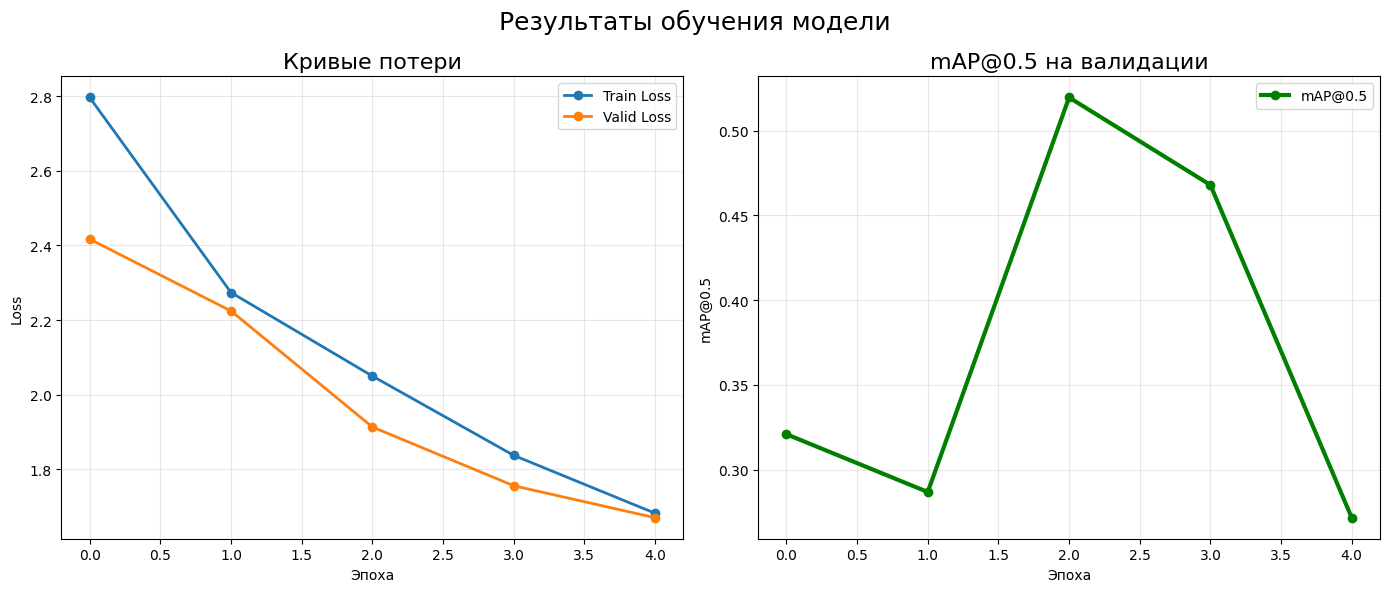

<Figure size 400x300 with 0 Axes>

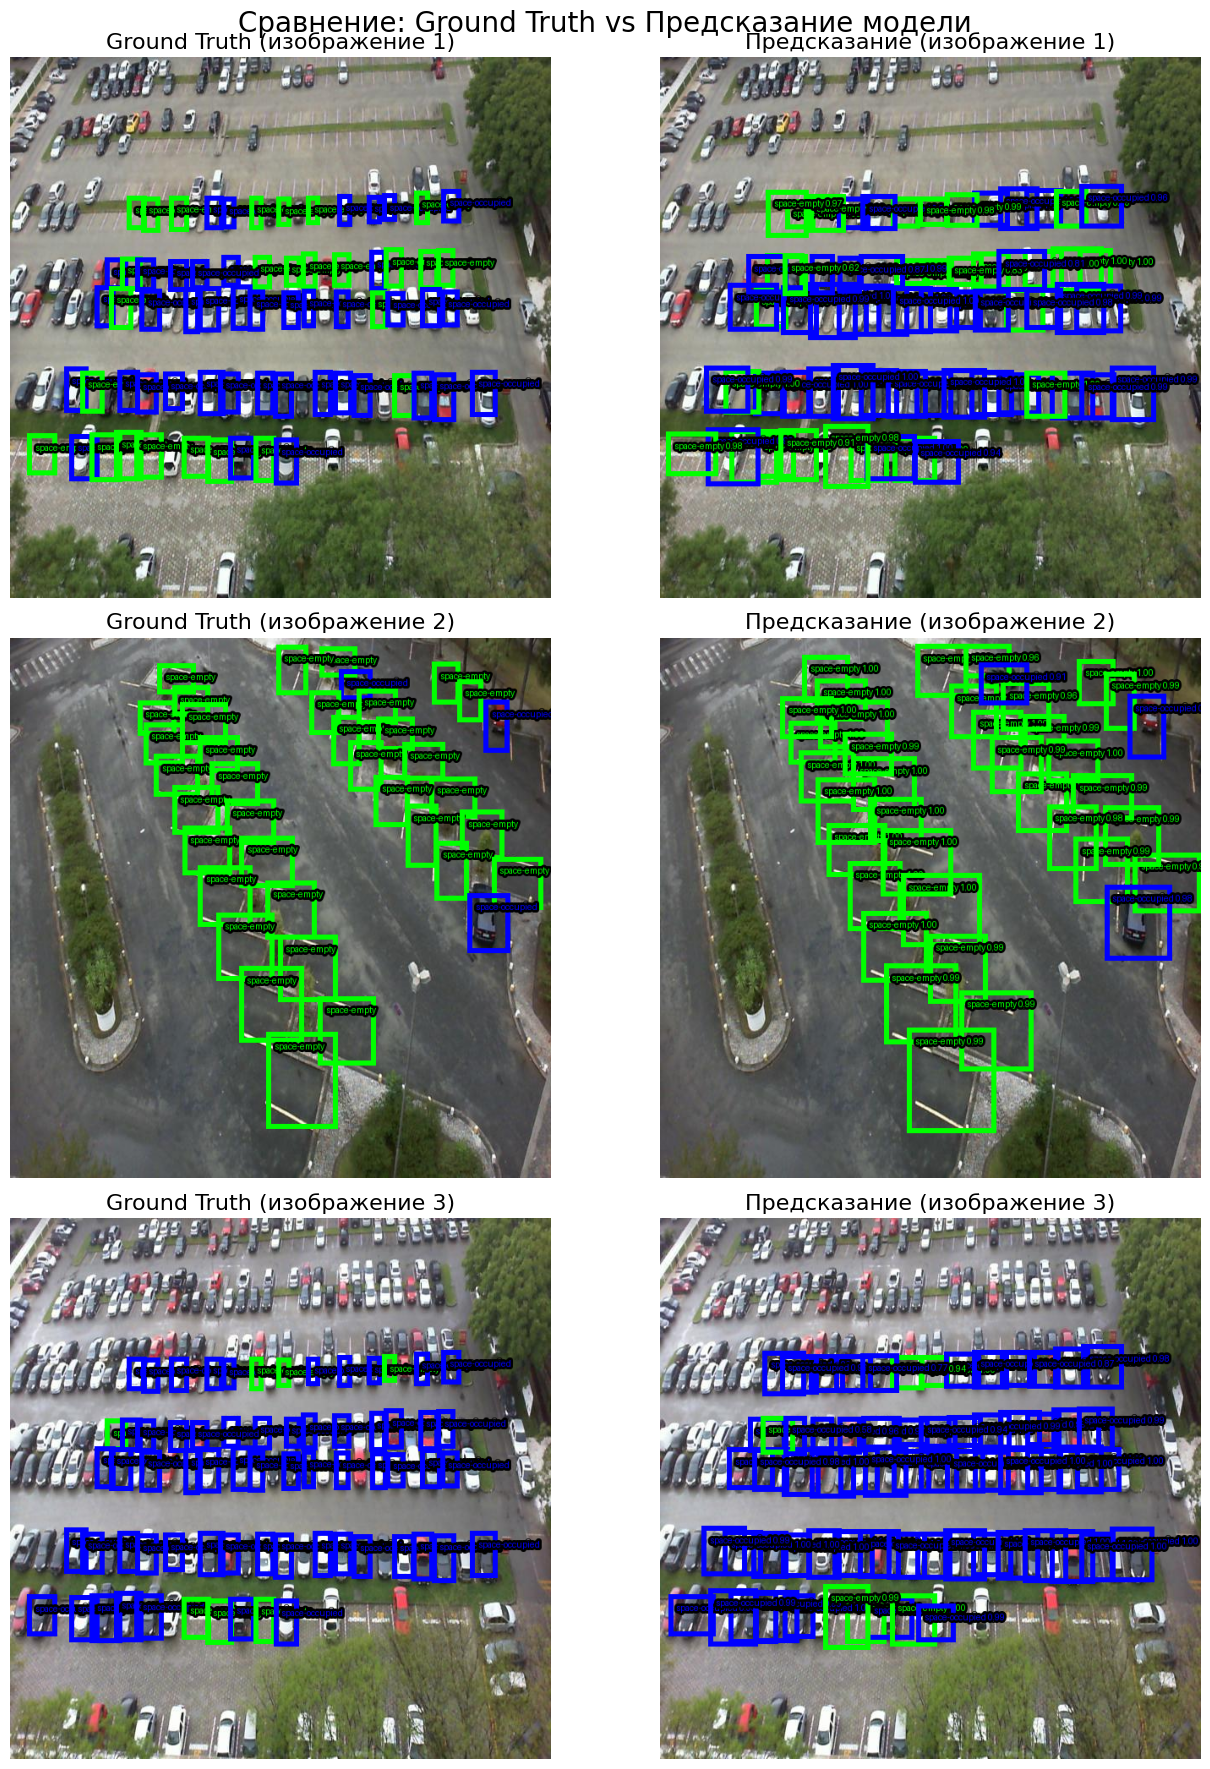

In [39]:
visualize_results(model_20, history_20, valid_dataset_improved_20, device, num_images=3)

Модель 2

In [40]:
# ================================== ЗАПУСК ==================================
model_13 = CraterDetectorResNet(num_classes=3, pretrained=True)

backbone_params = []
for name, param in model_13.named_parameters():
    if 'conv1' in name or 'bn1' in name or 'layer' in name:
        backbone_params.append(param)

# Head (новые слои) - больший LR
head_params = []
for name, param in model_13.named_parameters():
    if 'refine' in name or 'detect' in name:
        head_params.append(param)

optimizer_13 = torch.optim.AdamW([
    {'params': backbone_params, 'lr': 1e-4},   # Маленький LR для backbone
    {'params': head_params, 'lr': 1e-3}        # Больший LR для head
], weight_decay=1e-4)

scheduler_13 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_13, T_0=10, T_mult=2, eta_min=1e-6)

history_13 = train_model(model=model_13, train_loader=train_loader_13, valid_loader=valid_loader_13, optimizer=optimizer_13, scheduler=scheduler_13, file_name="best_yolo_13.pth", num_epochs=5)


Эпоха 1/5


Вычисление mAP: 100%|██████████| 42/42 [00:06<00:00,  6.70it/s]


Epoch 1/5
  Train Loss: 2.8258
  Val Loss:   2.3798
  mAP@0.5:0.95: 0.0243
  mAP@0.5     : 0.1227
  >>> Сохранена лучшая модель (mAP@0.5 = 0.1227)
Эпоха 2/5


Вычисление mAP: 100%|██████████| 42/42 [00:06<00:00,  6.64it/s]


Epoch 2/5
  Train Loss: 2.2323
  Val Loss:   2.1349
  mAP@0.5:0.95: 0.0426
  mAP@0.5     : 0.1790
  >>> Сохранена лучшая модель (mAP@0.5 = 0.1790)
Эпоха 3/5


Вычисление mAP: 100%|██████████| 42/42 [00:06<00:00,  6.91it/s]


Epoch 3/5
  Train Loss: 1.9857
  Val Loss:   1.8577
  mAP@0.5:0.95: 0.0755
  mAP@0.5     : 0.2917
  >>> Сохранена лучшая модель (mAP@0.5 = 0.2917)
Эпоха 4/5


Вычисление mAP: 100%|██████████| 42/42 [00:06<00:00,  6.97it/s]


Epoch 4/5
  Train Loss: 1.7808
  Val Loss:   1.6845
  mAP@0.5:0.95: 0.0694
  mAP@0.5     : 0.3116
  >>> Сохранена лучшая модель (mAP@0.5 = 0.3116)
Эпоха 5/5


Вычисление mAP: 100%|██████████| 42/42 [00:08<00:00,  5.19it/s]


Epoch 5/5
  Train Loss: 1.6174
  Val Loss:   1.4618
  mAP@0.5:0.95: 0.2594
  mAP@0.5     : 0.6883
  >>> Сохранена лучшая модель (mAP@0.5 = 0.6883)


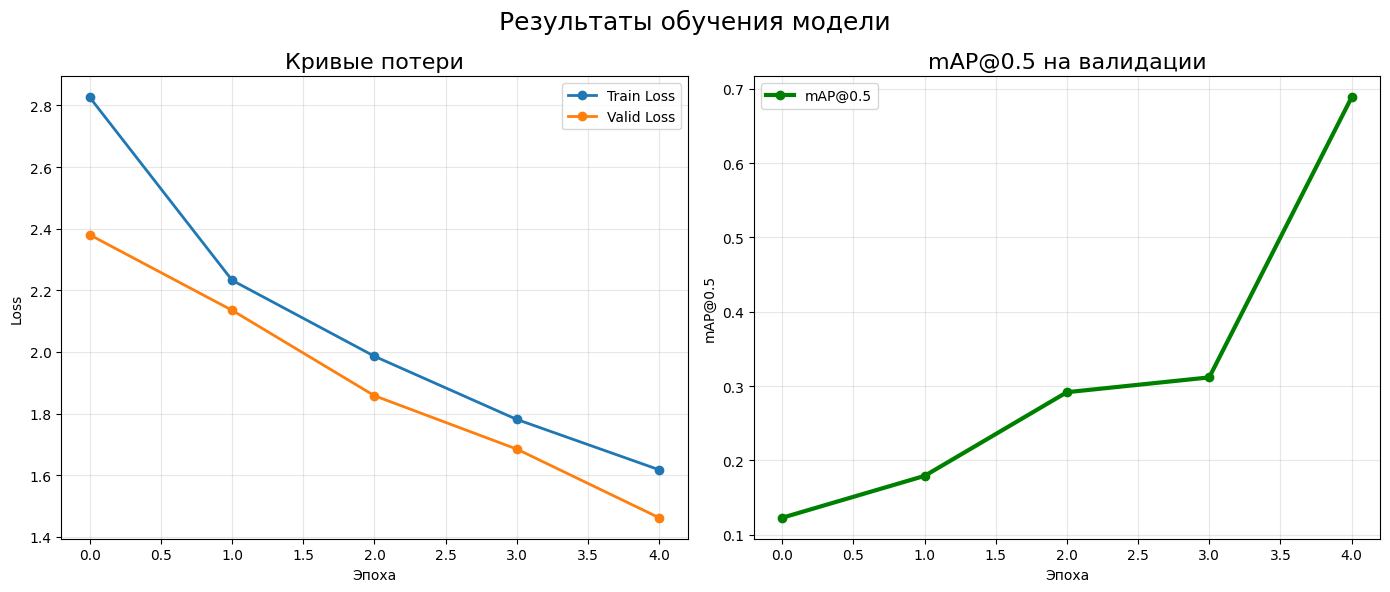

<Figure size 400x300 with 0 Axes>

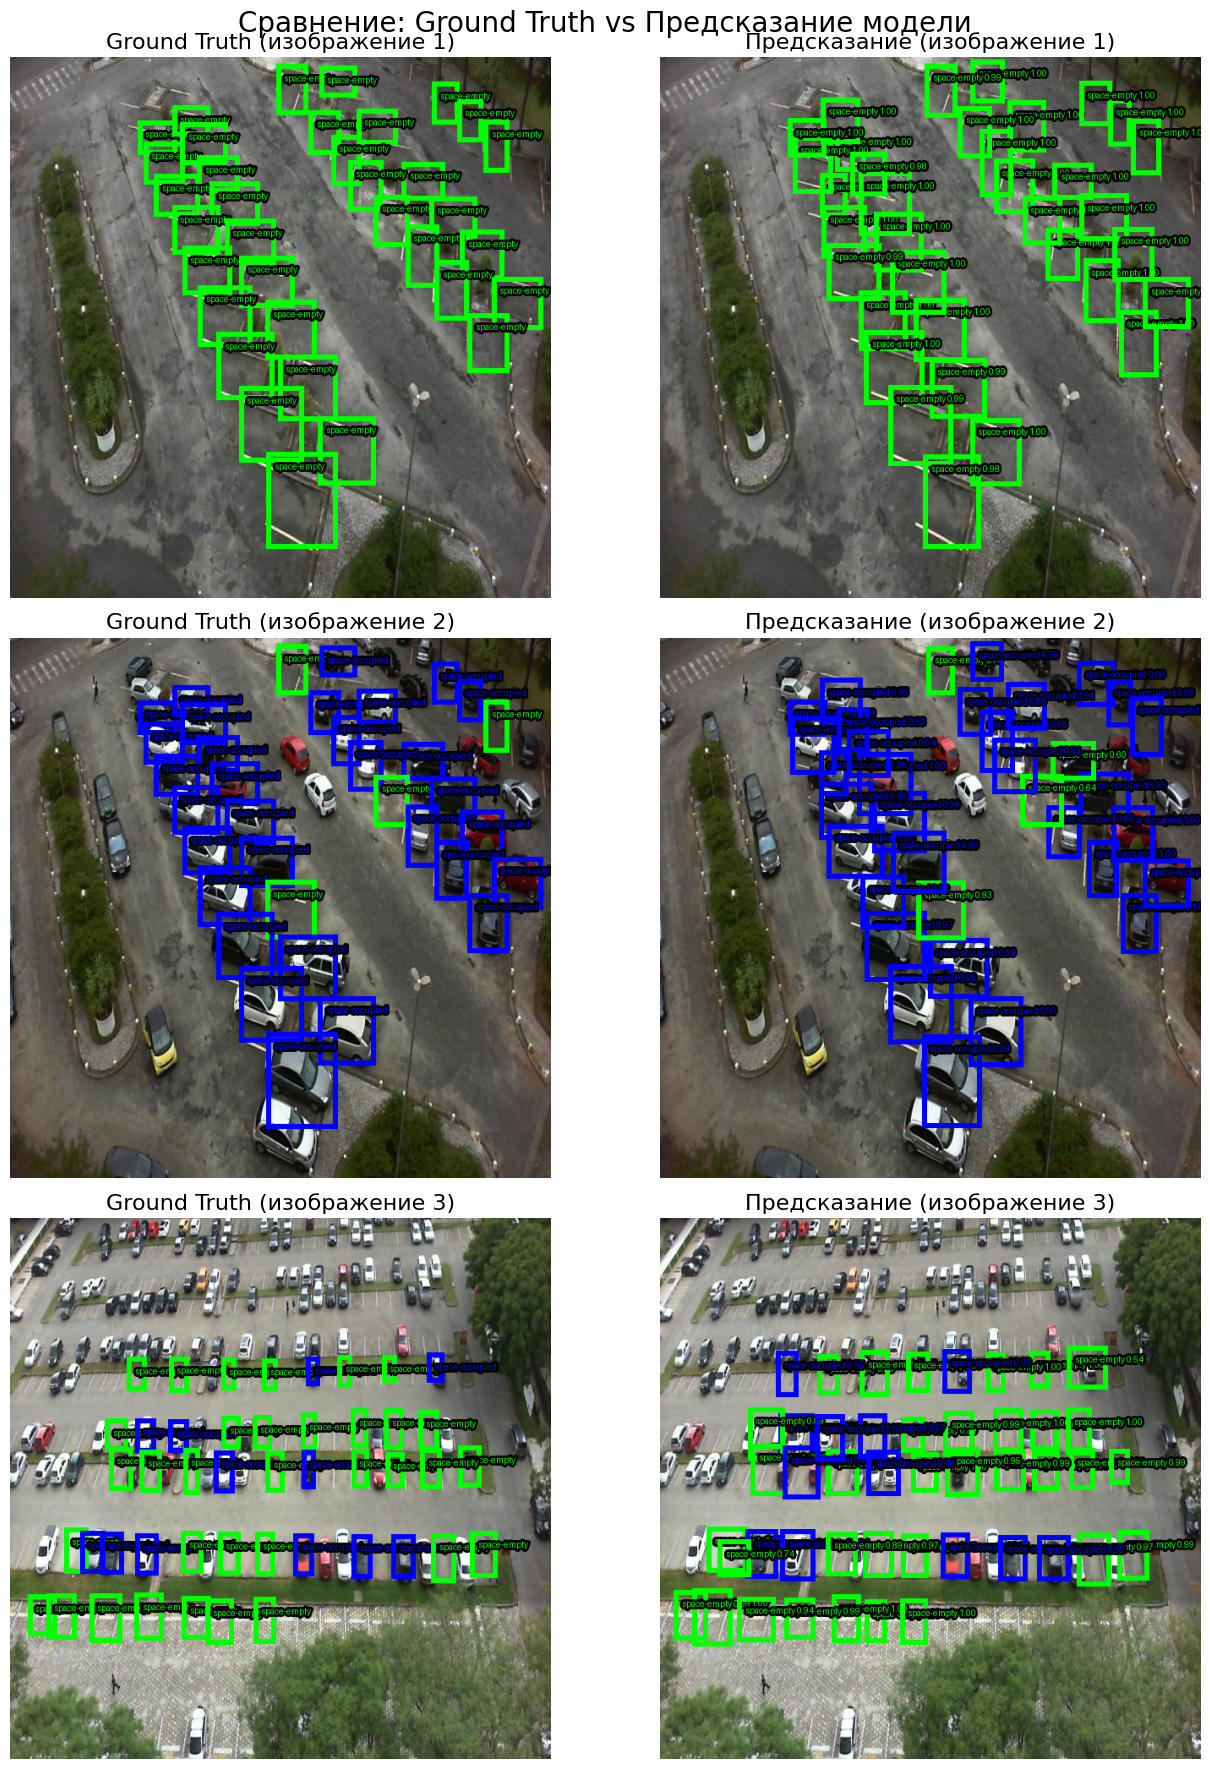

In [41]:
visualize_results(model_13, history_13, valid_dataset_improved_13, device, num_images=3)